In [1]:
import config
from config import load_ml_data

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import statsmodels.api as sm

from pprint import pprint

from scipy import stats
# define the chisqprob function due to a known bug.
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

{'calculate': {'analysis': True,
               'friends': False,
               'network': True,
               'uniquetweets': True,
               'uniqueusers': True},
 'data': {'dates': ['2018-03-11', '2018-03-12', '2018-03-13'],
          'eventname': "Givenchy's Death",
          'phrases': ['givenchy%20death', 'givenchy%20passed%20away'],
          'starttime': 'Mar 12 08:20:00 -0500 2018'},
 'path': {'cwd': '/home/ec2-user/uclresearchanalysis/data/givenchy',
          'ml': '/home/ec2-user/uclresearchanalysis/data/givenchy/pickle',
          'networkx': {'all': '/home/ec2-user/uclresearchanalysis/data/givenchy/pickle/networkx_all.dat',
                       'friends': '/home/ec2-user/uclresearchanalysis/data/givenchy/pickle/networkx_friends.dat',
                       'potential': '/home/ec2-user/uclresearchanalysis/data/givenchy/pickle/networkx_potential.dat'},
          'newcrawl': '/home/ec2-user/uclresearchanalysis/other/newcrawl.dat',
          'pickle': {'friends': '/h

ModuleNotFoundError: No module named 'seaborn'

In [67]:
def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    """pretty print for confusion matrixes"""
    columnwidth = max([len(x) for x in labels] + [5])  # 5 is value length
    empty_cell = " " * columnwidth
    # Print header
    print("    " + empty_cell, end=" ")
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=" ")
    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=" ")
        for j in range(len(labels)):
            cell = "%{0}.1f".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print(cell, end=" ")
        print()

In [183]:
def load_data(interval):
    data = load_ml_data(interval)
    data = data.reset_index(drop=True)
    print('[Original] data counts, with uninfected (0): {}, infected (1): {}'.format(
        data['label'].value_counts()[0],
        data['label'].value_counts()[1]
    ))
    data.groupby(['tCurrent','label']).size().unstack(fill_value=0).plot.bar()
    
    
#     for time in sorted(list(set(data.tCurrent))):
#         dataframe_slice_counts = data[data.tCurrent == time]['label'].value_counts()
#         print('Time {}, uninfected {}, infected {}, diff: {}'.format(
#             time,
#             dataframe_slice_counts[0],
#             dataframe_slice_counts[1],
#             dataframe_slice_counts[1] - dataframe_slice_counts[0]
#         ))
    
    
    # Perfrom up sampling to re-balance values
    diff = sum(data.label == 1) - sum(data.label == 0)
    append_indices = np.random.choice(data[data.label == 0].index, diff, replace=True)
    new_sample = data.loc[append_indices,:]
    data = pd.concat([data, new_sample])
    data = data.reset_index(drop=True)

    print('[Up-sampling] data counts, with uninfected (0): {}, infected (1): {}'.format(
        data['label'].value_counts()[0],
        data['label'].value_counts()[1],

    ))
    data.groupby(['tCurrent','label']).size().unstack(fill_value=0).plot.bar()
    
    return data

In [149]:
# Logistic Regression

# Feature selection using Recursive Feature Elimination
def feature_selection_logistic_regression(data, keep):
    y_col = ['label']
    # all columns apart from label
    x_col = list(data.columns)
    x_col.remove('label')
    
    X = data[x_col]
    X = X.astype('float')
    y = data[y_col]
    y = y.astype('int').values.ravel()
    
    logreg = LogisticRegression()
    
    rfe = RFE(logreg, n_features_to_select = 1)
    rfe = rfe.fit(X, y)
    
    print('Ranked features:')
    print(sorted(list(zip(rfe.ranking_, x_col))))
    
    x_col = [y for x, y in list(zip(rfe.ranking_, x_col)) if x <= keep]
    print('Columns to keep: {}'.format(x_col))
    
    X = data[x_col]
    X = X.astype('float')
    Y = data[y_col]
    y = Y.astype('int').values.ravel()

    logit_model=sm.Logit(y,X)
    result=logit_model.fit()
    print(result.summary())
    return X, Y

Loading data file from path /Users/lzhou/git/github/uclresearchanalysis/data/givenchy/pickle/30_data.dat
'Loaded 226984 entires'
[Original] data counts, with uninfected (0): 45869, infected (1): 181115
[Up-sampling] data counts, with uninfected (0): 181115, infected (1): 181115
[30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 390, 420, 450, 480, 510, 540, 570, 600, 630, 660, 690, 720, 750, 780, 810, 840, 870, 900, 930, 960, 990, 1020, 1050, 1080, 1110, 1140, 1170, 1200, 1230, 1260, 1290, 1320, 1350, 1380, 1410]


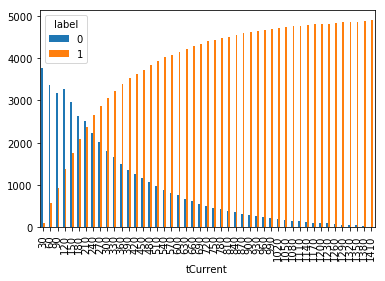

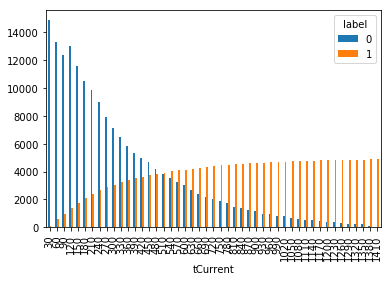

In [184]:
data = load_data(30)
print(sorted(list(set(data.tCurrent))))

In [109]:
# Logistic Regression

X, Y = feature_selection_logistic_regression(data, 10)

Loading data file from path /Users/lzhou/git/github/uclresearchanalysis/data/givenchy/pickle/30_data.dat
'Loaded 226984 entires'
[Original] data counts, with uninfected (0): 45869, infected (1): 181115
[Up-sampling] data counts, with uninfected (0): 181115, infected (1): 181115
Ranked features:
[(1, 'nNodes'), (2, 'kIn'), (3, 't0'), (4, 'tAverage'), (5, 't-1'), (6, 'tCurrent'), (7, 'kOutAverage'), (8, 'kOutMax'), (9, 'kOut-1'), (10, 'kOut0'), (11, 'kOutMin')]
Columns to keep: ['kIn', 'kOut-1', 'kOut0', 'kOutAverage', 'kOutMax', 'nNodes', 't-1', 't0', 'tAverage', 'tCurrent']
Optimization terminated successfully.
         Current function value: 0.468222
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:               362230
Model:                          Logit   Df Residuals:                   362220
Method:                           MLE   Df Model:                            9
D

In [ ]:
def split_data(X, Y):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
    

In [108]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

y_train = Y_train.astype('int').values.ravel()
y_test = Y_test.astype('int').values.ravel()
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
y_probs = logreg.predict_proba(X_test)
print(y_probs)
print('Accuracy of logistic regression classifier on test set: {:.5f}'.format(logreg.score(X_test, y_test)))

interval_time = []
interval_accuracy = []
for i in range(interval, 24 * 60, interval):
    val1 = data[data.tCurrent == i].index
    val2 = X_test.index
    indexes = [val for val in val1 if val in val2]

    X_interval = X_test.loc[indexes]
    y_interval = Y_test.loc[indexes].astype('int').values.ravel()
    interval_time.append(i)
    interval_accuracy.append(logreg.score(X_interval, y_interval))

interval_accuracy_df = pd.DataFrame(data = {
    'time_lapsed': interval_time, 
    'accuracy': interval_accuracy
})
plt.figure()
ax = sns.barplot(x="time_lapsed", y="accuracy", data=interval_accuracy_df)
plt.xticks(rotation=90)
plt.show()

kfold = model_selection.KFold(n_splits=10, random_state=7)
modelCV = LogisticRegression()
scoring = 'accuracy'
results = model_selection.cross_val_score(modelCV, X_train, y_train, cv=kfold, scoring=scoring)
print("10-fold cross validation average accuracy: %.5f" % (results.mean()))

cm = confusion_matrix(y_test, y_pred)

print_cm(cm, ['Not Infected', 'Infected'])

logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

Loading data file from path /Users/lzhou/git/github/uclresearchanalysis/data/givenchy/pickle/30_data.dat
'Loaded 226984 entires'
[Original] data counts, with uninfected (0): 45869, infected (1): 181115
[Up-sampling] data counts, with uninfected (0): 181115, infected (1): 181115
Ranked features:
[(1, 'nNodes'), (2, 'kIn'), (3, 't0'), (4, 'tCurrent'), (5, 't-1'), (6, 'kOutAverage'), (7, 'kOutMax'), (8, 'tAverage'), (9, 'kOut-1'), (10, 'kOut0'), (11, 'kOutMin')]
Columns to keep: ['kIn', 'kOut-1', 'kOut0', 'kOutAverage', 'kOutMax', 'nNodes', 't-1', 't0', 'tAverage', 'tCurrent']
Optimization terminated successfully.
         Current function value: 0.468129
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:               362230
Model:                          Logit   Df Residuals:                   362220
Method:                           MLE   Df Model:                            9
D

In [85]:
def run_logistic_regression_for_interval(interval):
    data = load_data(interval)
    
    # Feature selection using Recursive Feature Elimination
    x_col = ['kIn', 'kOut-1', 'kOut0', 'kOutAverage', 'kOutMax', 'kOutMin',
       'nNodes', 't-1', 't0', 'tAverage', 'tCurrent']
    y_col = ['label']
    X = data[x_col]
    X = X.astype('float')
    y = data[y_col]
    y = y.astype('int').values.ravel()
    logreg = LogisticRegression()
    rfe = RFE(logreg, 1)
    rfe = rfe.fit(X, y)
    pprint(sorted(list(zip(rfe.ranking_, x_col))))
    
    x_col = [y for x, y in list(zip(rfe.ranking_, x_col))]
    print(x_col)
    y_col = ['label']
    X = data[x_col]
    X = X.astype('float')
    Y = data[y_col]
    y = Y.astype('int').values.ravel()

    stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
    logit_model=sm.Logit(y,X)
    result=logit_model.fit()
    print(result.summary())

    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
    
    y_train = Y_train.astype('int').values.ravel()
    y_test = Y_test.astype('int').values.ravel()
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)
    y_probs = logreg.predict_proba(X_test)
    print(y_probs)
    print('Accuracy of logistic regression classifier on test set: {:.5f}'.format(logreg.score(X_test, y_test)))
    
    interval_time = []
    interval_accuracy = []
    for i in range(interval, 24 * 60, interval):
        val1 = data[data.tCurrent == i].index
        val2 = X_test.index
        indexes = [val for val in val1 if val in val2]
        
        X_interval = X_test.loc[indexes]
        y_interval = Y_test.loc[indexes].astype('int').values.ravel()
        interval_time.append(i)
        interval_accuracy.append(logreg.score(X_interval, y_interval))
        
    interval_accuracy_df = pd.DataFrame(data = {
        'time_lapsed': interval_time, 
        'accuracy': interval_accuracy
    })
    plt.figure()
    ax = sns.barplot(x="time_lapsed", y="accuracy", data=interval_accuracy_df)
    plt.xticks(rotation=90)
    plt.show()

    kfold = model_selection.KFold(n_splits=10, random_state=7)
    modelCV = LogisticRegression()
    scoring = 'accuracy'
    results = model_selection.cross_val_score(modelCV, X_train, y_train, cv=kfold, scoring=scoring)
    print("10-fold cross validation average accuracy: %.5f" % (results.mean()))
    
    cm = confusion_matrix(y_test, y_pred)
    
    print_cm(cm, ['Not Infected', 'Infected'])

    logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
    fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    plt.show()

Loading data file from path /Users/lzhou/git/github/uclresearchanalysis/data/givenchy/pickle/60_data.dat
'Loaded 111378 entires'
[Original] data counts, with uninfected (0): 21966, infected (1): 89412
[Up-sampling] data counts, with uninfected (0): 89412, infected (1): 89412
[(1, 'nNodes'),
 (2, 'kIn'),
 (3, 't0'),
 (4, 'tAverage'),
 (5, 't-1'),
 (6, 'tCurrent'),
 (7, 'kOutAverage'),
 (8, 'kOutMax'),
 (9, 'kOut-1'),
 (10, 'kOut0'),
 (11, 'kOutMin')]
['kIn', 'kOut-1', 'kOut0', 'kOutAverage', 'kOutMax', 'kOutMin', 'nNodes', 't-1', 't0', 'tAverage', 'tCurrent']
Optimization terminated successfully.
         Current function value: 0.479852
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:               178824
Model:                          Logit   Df Residuals:                   178813
Method:                           MLE   Df Model:                           10
Date:            

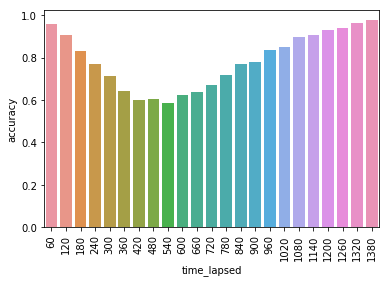

10-fold cross validation average accuracy: 0.78339
                 Not Infected     Infected 
    Not Infected      21567.0       5377.0 
        Infected       6277.0      20427.0 


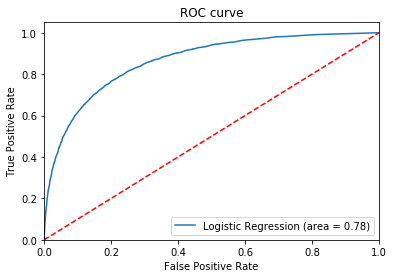

In [84]:
run_logistic_regression_for_interval(60)